In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import px4tools.ulog
import pandas
import os
import pickle
import scipy.interpolate
import px4tools.version

In [3]:
pandas.__version__

'0.19.99'

In [4]:
px4tools.version.git_revision

'3dc30500248723b3c555acb033ab85969e0d5ef8'

{'sensor_gyro_0_randomwalk_correlation_time': [497.52406777698928,
  341.17280940732462,
  310.21129313996721],
 'sensor_gyro_0_sig_bi': [0.00024548489539618078,
  0.00021836986760427672,
  0.0002121527961852067],
 'sensor_gyro_0_sig_rrw': [4.2006622294785469e-05,
  3.1129222243218572e-05,
  2.5693903056078307e-05],
 'sensor_gyro_0_sig_rw': [0.00044528797171410398,
  0.00044417578975201199,
  0.00046116195337056237],
 'sensor_gyro_0_tau_0': [3.0280968202761001,
  3.5570525487280706,
  3.6882780618553377],
 'sensor_gyro_0_tau_1': [18.360471489369473,
  24.714238901683888,
  31.08737244054343],
 'sensor_gyro_0_tau_2': [111.32633245234604,
  171.71340488290284,
  262.02599398672044]}

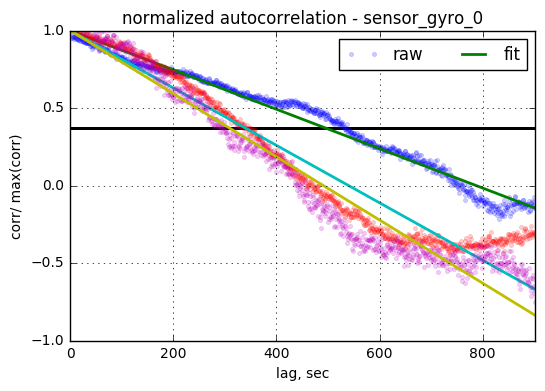

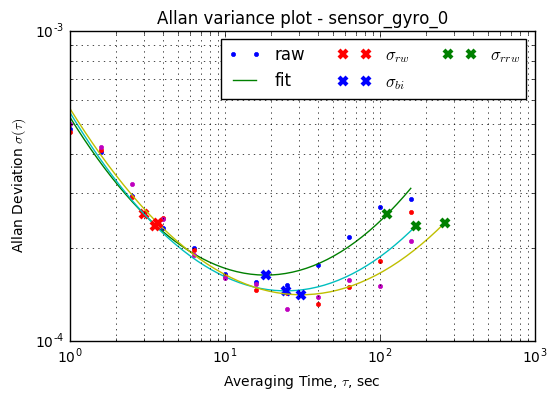

In [5]:
d_gyro = px4tools.ulog.cached_log_processing(
    log='/home/jgoppert/.ros/rootfs/fs/microsd/log/2017-01-09/11_39_44.ulg',
    msg_filter='sensor_gyro',
    processing_func=lambda x: x['sensor_gyro_0'].resample('1 s').agg('mean'),
    save_path='./logs/01-09-17-sitl-gyro_0.ulg',
    force_processing=False)
px4tools.ulog.noise_analysis_sensor(d_gyro, 'sensor_gyro_0')

{'sensor_accel_0_randomwalk_correlation_time': [268.68139981595709,
  209.78425823185722,
  480.42062094306607],
 'sensor_accel_0_sig_bi': [0.011793571078171044,
  0.011316792920162796,
  0.011367329123655874],
 'sensor_accel_0_sig_rrw': [0.0052528103190016811,
  0.0046480979277521931,
  0.0043801939632010321],
 'sensor_accel_0_sig_rw': [0.005232289412308566,
  0.0052827182792559218,
  0.0052393596670073164],
 'sensor_accel_0_tau_0': [0.11532245572981377,
  0.12387462436860534,
  0.11187226898462603],
 'sensor_accel_0_tau_1': [1.7252842862495594,
  1.9685334956290319,
  2.071788879356375],
 'sensor_accel_0_tau_2': [25.811155767905859,
  31.282630669236276,
  38.367945868824847]}

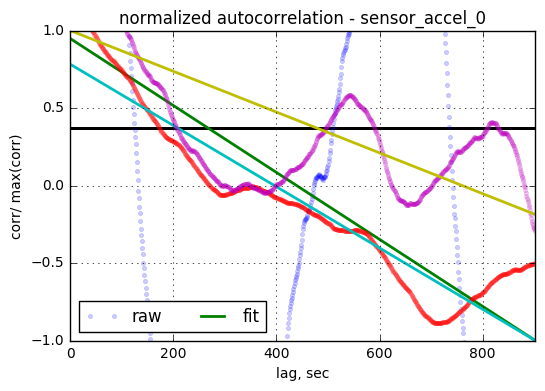

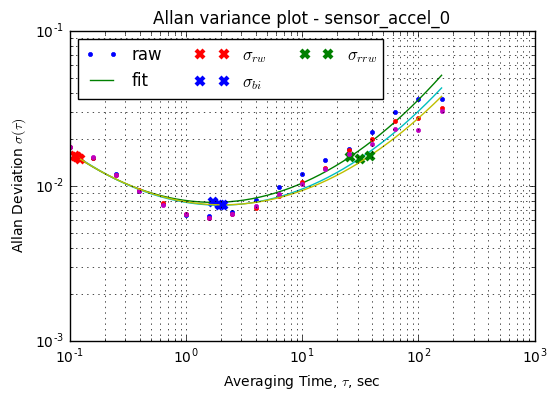

In [6]:
d_accel = px4tools.ulog.cached_log_processing(
    log='/home/jgoppert/.ros/rootfs/fs/microsd/log/2017-01-09/11_39_44.ulg',
    msg_filter='sensor_accel',
    processing_func=lambda x: x['sensor_accel_0'].resample('100 ms').agg('mean'),
    save_path='./logs/01-09-17-sitl-accel_0.ulg',
    force_processing=False)
px4tools.ulog.noise_analysis_sensor(d_accel, 'sensor_accel_0')

In [12]:
d_mag = px4tools.ulog.cached_log_processing(
    log='/home/jgoppert/.ros/rootfs/fs/microsd/log/2017-01-09/11_39_44.ulg',
    msg_filter='sensor_mag',
    processing_func=lambda x: x['sensor_mag_0'].resample('100 ms').agg('mean'),
    save_path='./logs/01-09-17-sitl-mag_0.ulg',
    force_processing=False)

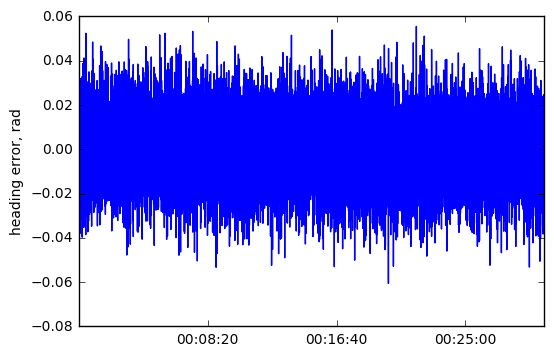

In [16]:
B_b = np.array([
        d_mag.t_sensor_mag_0__f_x.ffill(), d_mag.t_sensor_mag_0__f_y.ffill(), d_mag.t_sensor_mag_0__f_z.ffill()]).T
B_b_mean = B_b.mean(axis=0)
B_b_mean[2] = 0
B_b[:,2] = 0
mag_heading_error = pandas.Series(
    np.arcsin(np.cross(B_b_mean, B_b)[:,2]/np.linalg.norm(B_b, axis=1)/np.linalg.norm(B_b_mean)),
    d_mag.index, name='heading error')
mag_heading_error.plot()
ylabel('heading error, rad')

{'sig_bi': 0,
 'sig_rrw': 0,
 'sig_rw': 0.0047145171303446046,
 'tau_0': 0.82502646895713294,
 'tau_1': nan,
 'tau_2': nan}

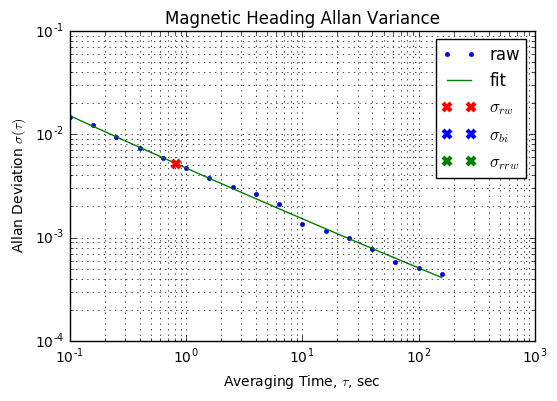

In [17]:
res_mag = px4tools.plot_allan_std_dev(mag_heading_error)
legend()
title('Magnetic Heading Allan Variance')
res_mag

502.53172809553462

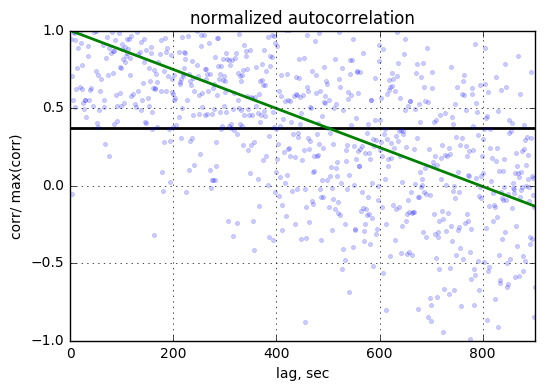

In [18]:
px4tools.plot_autocorrelation(mag_heading_error)

({'sig_bi': 0,
  'sig_rrw': 0,
  'sig_rw': 0.011988200563997927,
  'tau_0': 1,
  'tau_1': nan,
  'tau_2': nan},
 1121.1864448826334)

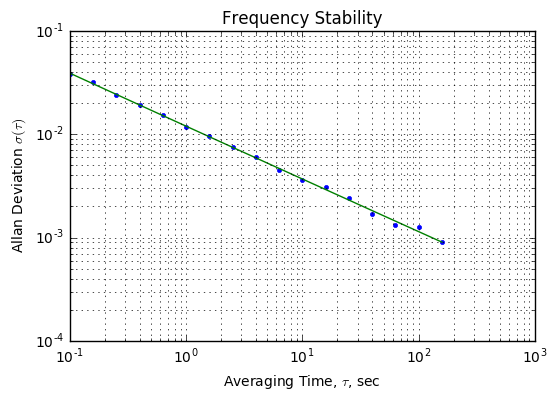

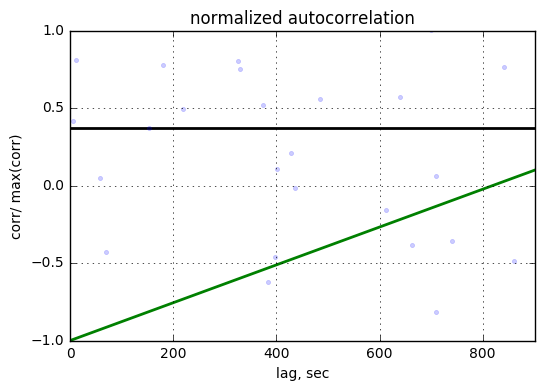

In [19]:
d_baro = px4tools.ulog.cached_log_processing(
    log='/home/jgoppert/.ros/rootfs/fs/microsd/log/2017-01-09/11_39_44.ulg',
    msg_filter='sensor_baro',
    processing_func=lambda x: x['sensor_baro_0'].resample('100 ms').agg('mean'),
    save_path='./logs/01-09-17-sitl-baro_0.pkl',
    force_processing=False)
res = px4tools.ulog.plot_allan_std_dev(d_baro.t_sensor_baro_0__f_altitude)
figure()
tau = px4tools.ulog.plot_autocorrelation(d_baro.t_sensor_baro_0__f_altitude)
res, tau

({'sig_bi': 0,
  'sig_rrw': 0,
  'sig_rw': 0.0014896578493739626,
  'tau_0': 0.83410174142819704,
  'tau_1': nan,
  'tau_2': nan},
 1156.2443561384398)

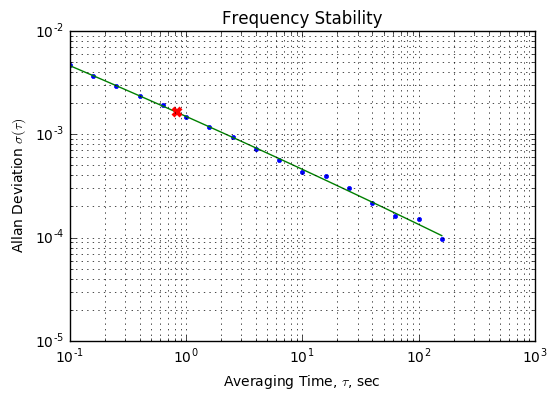

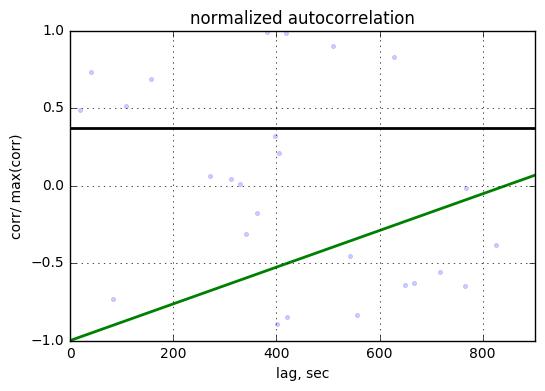

In [24]:
d_baro_f = px4tools.ulog.cached_log_processing(
    log='/home/jgoppert/.ros/rootfs/fs/microsd/log/2017-01-09/11_39_44.ulg',
    msg_filter='sensor_baro',
    processing_func=lambda x: x['sensor_baro_0'],
    save_path='./logs/01-09-17-sitl-baro_0_full.pkl',
    force_processing=False)
res = px4tools.ulog.plot_allan_std_dev(d_baro_f.t_sensor_baro_0__f_pressure)
figure()
tau = px4tools.ulog.plot_autocorrelation(d_baro_f.t_sensor_baro_0__f_pressure)
res, tau

In [27]:
d_gps = px4tools.ulog.cached_log_processing(
    log='/home/jgoppert/.ros/rootfs/fs/microsd/log/2017-01-09/11_39_44.ulg',
    msg_filter='vehicle_gps_position',
    processing_func=lambda x: x['vehicle_gps_position_0'],
    save_path='./logs/01-09-17-sitl-gps.pkl',
    force_processing=False)